# Initialize

In [1]:
#@title Import {display-mode: "form"}
import math
import torch
from torch import nn

# Model

In [2]:
#@title Swish {display-mode: "form"}
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [3]:
#@title FeatureEx1d {display-mode: "form"}
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [4]:
#@title SEblock {display-mode: "form"}
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [5]:
#@title ConvBNFirst {display-mode: "form"}
class ConvBNFirst(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size=(3, 257), stride=(1, 257), padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [6]:
#@title ConvBN {display-mode: "form"}
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [7]:
#@title DropConnect {display-mode: "form"}
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [8]:
#@title BMConvBlock {display-mode: "form"}
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=0, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [9]:
#@title Flatten {display-mode: "form"}
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [10]:
#@title MultiModalNet {display-mode: "form"}
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=2.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_1d_features=10,
               num_classes=4,
               input_ch=3):
    super().__init__()
    '''
    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBNFirst(input_ch, ch_out), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    '''
    features = [BMConvBlock(input_ch, 64, expand_ratio=6, stride=(1,257), kernel_size=(1, 257))]
    features.extend([BMConvBlock(64, 64, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([BMConvBlock(64, 64, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([BMConvBlock(64, 64, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(64, ch_last, 1), Swish()])

    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, 128)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

    self.features1d = nn.Sequential(
        nn.Linear(num_1d_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features1d(x[0])
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)

    return x

# Dataset

In [11]:
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"

In [12]:
import shutil
import os


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/" + dirs, data_dir + dirs)

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"  + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = data_dir + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

Q1 9200
Q2 9200
Q3 9200
Q4 9200
Q1 9200
Q2 9200
Q3 9200
Q4 9200


In [13]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)


      for f in file_list:
        split_num = int(f.split(".")[1].split("_")[-1])
        if split_num % 5 == 4:
          valid_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))
        else:
          train_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))

  
  return train_file_list, valid_file_list


In [14]:
from torch.utils import data
import numpy as np
import librosa
import pickle
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)


  def __getitem__(self, index):
    pickle_path = self.file_list[index]
    x,y = pickle.load(open(pickle_path, mode="rb"))
    return x, y


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset1 shape:", train_dataset.__getitem__(index)[0][0].size())
print("Dataset2 shape:", train_dataset.__getitem__(index)[0][1].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  29600
/content/datas/Q2/Q2.MT0005026798_7.wav.pickle
検証データ数 :  7200
/content/datas/Q2/Q2.MT0000732821_24.wav.pickle
Dataset1 shape: torch.Size([26])
Dataset2 shape: torch.Size([1, 431, 257])
Dataset label: 1


# DataLoader

In [15]:
# バッチサイズの指定
batch_size = 32

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs[0].size())
print(inputs[1].size())
print(labels)


torch.Size([32, 26])
torch.Size([32, 1, 431, 257])
tensor([1, 3, 2, 0, 0, 3, 2, 3, 3, 1, 2, 2, 3, 3, 0, 3, 0, 2, 1, 3, 2, 2, 2, 0,
        1, 2, 3, 3, 2, 1, 1, 0])


# Optimizer, Criterion

In [16]:
torch_clearlizer = False #@param {type: "boolean"}

if torch_clearlizer:
  del train_dataset
  del valid_dataset
  del train_dataloader
  del valid_dataloader
  del labels
  del loss_hist
  del acc_hist
  del optimizer
  del criterion
  torch.cuda.empty_cache()

In [17]:
from torch import optim

model     = MultiModalNet(input_ch=1, num_classes=4, num_1d_features=train_dataset.__getitem__(index)[0][0].size(0)).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.1) 
criterion = nn.CrossEntropyLoss()

SGD -> じわっとloss減ってく


# Training

In [18]:
from tqdm import tqdm
# エポック数
num_epochs = 20


loss_hist = [[],[]]
acc_hist = [[],[]]

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-------------')
  
  for phase in ['train', 'valid']:
      
    if phase == 'train':
      # モデルを訓練モードに設定
      model.train()
    else:
      # モデルを推論モードに設定
      model.eval()
    
    # 損失和
    epoch_loss = 0.0
    # 正解数
    epoch_corrects = 0
    
    # DataLoaderからデータをバッチごとに取り出す
    with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
      pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
      for inputs, labels in pbar:
        inputs = [inputs[0].to('cuda') , inputs[1].to('cuda')]
        labels = labels.to('cuda')
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          
          # 損失を計算
          loss = criterion(outputs, labels)
          
          # ラベルを予測
          _, preds = torch.max(outputs, 1)
          
          # 訓練時はバックプロパゲーション
          if phase == 'train':
            # 逆伝搬の計算
            loss.backward()
            # パラメータの更新
            optimizer.step()
          
          # イテレーション結果の計算
          # lossの合計を更新
          # PyTorchの仕様上各バッチ内での平均のlossが計算される。
          # データ数を掛けることで平均から合計に変換をしている。
          # 損失和は「全データの損失/データ数」で計算されるため、
          # 平均のままだと損失和を求めることができないため。
          l = loss.item()
          epoch_loss += l * inputs[0].size(0)
          pbar.set_postfix(dict(loss=l))

          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
    acc_hist[0].append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

    print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))

Epoch 1/20
-------------


[train] Epoch 1: 100%|██████████| 925/925 [02:17<00:00,  6.75batch/s, loss=1.02]


[train] Epoch 1 Result: Loss: 1.1959 Acc: 0.5239



[valid] Epoch 1: 100%|██████████| 225/225 [00:29<00:00,  7.52batch/s, loss=1.26]


[valid] Epoch 1 Result: Loss: 1.0954 Acc: 0.6418

Epoch 2/20
-------------


[train] Epoch 2: 100%|██████████| 925/925 [02:07<00:00,  7.28batch/s, loss=1.02]


[train] Epoch 2 Result: Loss: 1.0767 Acc: 0.6590



[valid] Epoch 2: 100%|██████████| 225/225 [00:28<00:00,  7.77batch/s, loss=0.916]


[valid] Epoch 2 Result: Loss: 1.1265 Acc: 0.6044

Epoch 3/20
-------------


[train] Epoch 3: 100%|██████████| 925/925 [02:04<00:00,  7.41batch/s, loss=1]


[train] Epoch 3 Result: Loss: 1.0274 Acc: 0.7113



[valid] Epoch 3: 100%|██████████| 225/225 [00:28<00:00,  7.76batch/s, loss=0.953]


[valid] Epoch 3 Result: Loss: 1.0032 Acc: 0.7349

Epoch 4/20
-------------


[train] Epoch 4: 100%|██████████| 925/925 [02:07<00:00,  7.26batch/s, loss=0.96]


[train] Epoch 4 Result: Loss: 0.9926 Acc: 0.7465



[valid] Epoch 4: 100%|██████████| 225/225 [00:28<00:00,  7.89batch/s, loss=0.928]


[valid] Epoch 4 Result: Loss: 0.9561 Acc: 0.7869

Epoch 5/20
-------------


[train] Epoch 5: 100%|██████████| 925/925 [02:06<00:00,  7.34batch/s, loss=1.12]


[train] Epoch 5 Result: Loss: 0.9625 Acc: 0.7801



[valid] Epoch 5: 100%|██████████| 225/225 [00:37<00:00,  6.01batch/s, loss=0.978]


[valid] Epoch 5 Result: Loss: 0.9447 Acc: 0.7972

Epoch 6/20
-------------


[train] Epoch 6: 100%|██████████| 925/925 [03:05<00:00,  4.99batch/s, loss=0.806]


[train] Epoch 6 Result: Loss: 0.9396 Acc: 0.8022



[valid] Epoch 6: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=1.04]


[valid] Epoch 6 Result: Loss: 0.9187 Acc: 0.8229

Epoch 7/20
-------------


[train] Epoch 7: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=1]


[train] Epoch 7 Result: Loss: 0.9213 Acc: 0.8201



[valid] Epoch 7: 100%|██████████| 225/225 [00:43<00:00,  5.18batch/s, loss=0.972]


[valid] Epoch 7 Result: Loss: 0.8904 Acc: 0.8522

Epoch 8/20
-------------


[train] Epoch 8: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.885]


[train] Epoch 8 Result: Loss: 0.9059 Acc: 0.8366



[valid] Epoch 8: 100%|██████████| 225/225 [00:44<00:00,  5.02batch/s, loss=0.994]


[valid] Epoch 8 Result: Loss: 0.8846 Acc: 0.8564

Epoch 9/20
-------------


[train] Epoch 9: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.867]


[train] Epoch 9 Result: Loss: 0.8899 Acc: 0.8528



[valid] Epoch 9: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.936]


[valid] Epoch 9 Result: Loss: 0.8665 Acc: 0.8753

Epoch 10/20
-------------


[train] Epoch 10: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.829]


[train] Epoch 10 Result: Loss: 0.8792 Acc: 0.8637



[valid] Epoch 10: 100%|██████████| 225/225 [00:44<00:00,  5.01batch/s, loss=0.88]


[valid] Epoch 10 Result: Loss: 0.8658 Acc: 0.8774

Epoch 11/20
-------------


[train] Epoch 11: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.888]


[train] Epoch 11 Result: Loss: 0.8693 Acc: 0.8741



[valid] Epoch 11: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.918]


[valid] Epoch 11 Result: Loss: 0.8654 Acc: 0.8772

Epoch 12/20
-------------


[train] Epoch 12: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.81]


[train] Epoch 12 Result: Loss: 0.8658 Acc: 0.8771



[valid] Epoch 12: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.97]


[valid] Epoch 12 Result: Loss: 0.8437 Acc: 0.8997

Epoch 13/20
-------------


[train] Epoch 13: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.911]


[train] Epoch 13 Result: Loss: 0.8524 Acc: 0.8902



[valid] Epoch 13: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.993]


[valid] Epoch 13 Result: Loss: 0.8491 Acc: 0.8943

Epoch 14/20
-------------


[train] Epoch 14: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.868]


[train] Epoch 14 Result: Loss: 0.8429 Acc: 0.9004



[valid] Epoch 14: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.871]


[valid] Epoch 14 Result: Loss: 0.8226 Acc: 0.9207

Epoch 15/20
-------------


[train] Epoch 15: 100%|██████████| 925/925 [03:01<00:00,  5.08batch/s, loss=0.885]


[train] Epoch 15 Result: Loss: 0.8358 Acc: 0.9076



[valid] Epoch 15: 100%|██████████| 225/225 [00:44<00:00,  5.05batch/s, loss=0.845]


[valid] Epoch 15 Result: Loss: 0.8264 Acc: 0.9179

Epoch 16/20
-------------


[train] Epoch 16: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.807]


[train] Epoch 16 Result: Loss: 0.8283 Acc: 0.9146



[valid] Epoch 16: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.867]


[valid] Epoch 16 Result: Loss: 0.8218 Acc: 0.9218

Epoch 17/20
-------------


[train] Epoch 17: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.779]


[train] Epoch 17 Result: Loss: 0.8223 Acc: 0.9209



[valid] Epoch 17: 100%|██████████| 225/225 [00:43<00:00,  5.18batch/s, loss=1.05]


[valid] Epoch 17 Result: Loss: 0.8472 Acc: 0.8951

Epoch 18/20
-------------


[train] Epoch 18: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.829]


[train] Epoch 18 Result: Loss: 0.8199 Acc: 0.9230



[valid] Epoch 18: 100%|██████████| 225/225 [00:44<00:00,  5.00batch/s, loss=0.835]


[valid] Epoch 18 Result: Loss: 0.8246 Acc: 0.9176

Epoch 19/20
-------------


[train] Epoch 19: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.834]


[train] Epoch 19 Result: Loss: 0.8127 Acc: 0.9311



[valid] Epoch 19: 100%|██████████| 225/225 [00:43<00:00,  5.19batch/s, loss=0.91]


[valid] Epoch 19 Result: Loss: 0.8000 Acc: 0.9436

Epoch 20/20
-------------


[train] Epoch 20: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.805]


[train] Epoch 20 Result: Loss: 0.8032 Acc: 0.9406



[valid] Epoch 20: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.879]

[valid] Epoch 20 Result: Loss: 0.7974 Acc: 0.9456



# 1
```
    features = [BMConvBlock(input_ch, 2024, expand_ratio=6, stride=(1,257), kernel_size=(1, 257))]
    features.extend([BMConvBlock(2024, 4048, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([BMConvBlock(4048, 8096, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([ConvBN(8096, 16192, stride=(2,1), kernel_size=(5,1), groups=8096), Swish()])

```
```
Epoch 1/200
-------------
[train] Epoch 1: 100%|██████████| 925/925 [44:13<00:00,  2.87s/batch, loss=1.07]
[train] Epoch 1 Result: Loss: 1.1820 Acc: 0.5304

[valid] Epoch 1: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.992]
[valid] Epoch 1 Result: Loss: 1.1202 Acc: 0.6054

Epoch 2/200
-------------
[train] Epoch 2: 100%|██████████| 925/925 [44:00<00:00,  2.85s/batch, loss=1.05]
[train] Epoch 2 Result: Loss: 1.0772 Acc: 0.6548

[valid] Epoch 2: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.892]
[valid] Epoch 2 Result: Loss: 1.0357 Acc: 0.7015

Epoch 3/200
-------------
[train] Epoch 3: 100%|██████████| 925/925 [43:57<00:00,  2.85s/batch, loss=1.03]
[train] Epoch 3 Result: Loss: 1.0292 Acc: 0.7084

[valid] Epoch 3: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.963]
[valid] Epoch 3 Result: Loss: 1.0089 Acc: 0.7304

Epoch 4/200
-------------
[train] Epoch 4: 100%|██████████| 925/925 [43:56<00:00,  2.85s/batch, loss=0.995]
[train] Epoch 4 Result: Loss: 0.9938 Acc: 0.7454

[valid] Epoch 4: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.779]
[valid] Epoch 4 Result: Loss: 0.9411 Acc: 0.8014

Epoch 5/200
-------------
[train] Epoch 5: 100%|██████████| 925/925 [43:57<00:00,  2.85s/batch, loss=0.946]
[train] Epoch 5 Result: Loss: 0.9605 Acc: 0.7811

[valid] Epoch 5: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.751]
[valid] Epoch 5 Result: Loss: 0.9295 Acc: 0.8118

Epoch 6/200
-------------
[train] Epoch 6: 100%|██████████| 925/925 [43:57<00:00,  2.85s/batch, loss=0.937]
[train] Epoch 6 Result: Loss: 0.9304 Acc: 0.8112

[valid] Epoch 6: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.784]
[valid] Epoch 6 Result: Loss: 0.9065 Acc: 0.8354

Epoch 7/200
-------------
[train] Epoch 7: 100%|██████████| 925/925 [43:57<00:00,  2.85s/batch, loss=0.872]
[train] Epoch 7 Result: Loss: 0.9051 Acc: 0.8369

[valid] Epoch 7: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.744]
[valid] Epoch 7 Result: Loss: 0.8960 Acc: 0.8476

Epoch 8/200
-------------
[train] Epoch 8: 100%|██████████| 925/925 [43:58<00:00,  2.85s/batch, loss=0.831]
[train] Epoch 8 Result: Loss: 0.8870 Acc: 0.8560

[valid] Epoch 8: 100%|██████████| 225/225 [04:38<00:00,  1.24s/batch, loss=0.784]
[valid] Epoch 8 Result: Loss: 0.8694 Acc: 0.8724

Epoch 9/200
-------------
[train] Epoch 9:  39%|███▉      | 362/925 [17:12<26:47,  2.85s/batch, loss=0.908]
```

#2
```
    features = [BMConvBlock(input_ch, 2024, expand_ratio=6, stride=(1,257), kernel_size=(1, 257))]
    features.extend([BMConvBlock(2024, 4048, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([BMConvBlock(4048, 4048, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
```
```
Epoch 1/200
-------------
[train] Epoch 1: 100%|██████████| 925/925 [34:12<00:00,  2.22s/batch, loss=1.04]
[train] Epoch 1 Result: Loss: 1.1808 Acc: 0.5448

[valid] Epoch 1: 100%|██████████| 225/225 [03:18<00:00,  1.13batch/s, loss=0.987]
[valid] Epoch 1 Result: Loss: 1.1004 Acc: 0.6297

Epoch 2/200
-------------
[train] Epoch 2: 100%|██████████| 925/925 [34:02<00:00,  2.21s/batch, loss=1.01]
[train] Epoch 2 Result: Loss: 1.0683 Acc: 0.6658

[valid] Epoch 2: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.868]
[valid] Epoch 2 Result: Loss: 1.0424 Acc: 0.6924

Epoch 3/200
-------------
[train] Epoch 3: 100%|██████████| 925/925 [34:01<00:00,  2.21s/batch, loss=0.978]
[train] Epoch 3 Result: Loss: 1.0177 Acc: 0.7206

[valid] Epoch 3: 100%|██████████| 225/225 [03:18<00:00,  1.13batch/s, loss=0.921]
[valid] Epoch 3 Result: Loss: 1.0024 Acc: 0.7364

Epoch 4/200
-------------
[train] Epoch 4: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=1.12]
[train] Epoch 4 Result: Loss: 0.9959 Acc: 0.7438

[valid] Epoch 4: 100%|██████████| 225/225 [03:17<00:00,  1.14batch/s, loss=0.895]
[valid] Epoch 4 Result: Loss: 0.9548 Acc: 0.7883

Epoch 5/200
-------------
[train] Epoch 5: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.966]
[train] Epoch 5 Result: Loss: 0.9637 Acc: 0.7767

[valid] Epoch 5: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.864]
[valid] Epoch 5 Result: Loss: 0.9510 Acc: 0.7882

Epoch 6/200
-------------
[train] Epoch 6: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.882]
[train] Epoch 6 Result: Loss: 0.9412 Acc: 0.8004

[valid] Epoch 6: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.873]
[valid] Epoch 6 Result: Loss: 0.9161 Acc: 0.8242

Epoch 7/200
-------------
[train] Epoch 7: 100%|██████████| 925/925 [33:59<00:00,  2.21s/batch, loss=0.914]
[train] Epoch 7 Result: Loss: 0.9177 Acc: 0.8239

[valid] Epoch 7: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.779]
[valid] Epoch 7 Result: Loss: 0.8891 Acc: 0.8528

Epoch 8/200
-------------
[train] Epoch 8: 100%|██████████| 925/925 [33:59<00:00,  2.21s/batch, loss=0.785]
[train] Epoch 8 Result: Loss: 0.8993 Acc: 0.8430

[valid] Epoch 8: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.842]
[valid] Epoch 8 Result: Loss: 0.8591 Acc: 0.8856

Epoch 9/200
-------------
[train] Epoch 9: 100%|██████████| 925/925 [33:59<00:00,  2.21s/batch, loss=0.884]
[train] Epoch 9 Result: Loss: 0.8849 Acc: 0.8568

[valid] Epoch 9: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=1.02]
[valid] Epoch 9 Result: Loss: 0.9651 Acc: 0.7739

Epoch 10/200
-------------
[train] Epoch 10: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.911]
[train] Epoch 10 Result: Loss: 0.8677 Acc: 0.8751

[valid] Epoch 10: 100%|██████████| 225/225 [03:18<00:00,  1.13batch/s, loss=0.788]
[valid] Epoch 10 Result: Loss: 0.8355 Acc: 0.9075

Epoch 11/200
-------------
[train] Epoch 11: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.901]
[train] Epoch 11 Result: Loss: 0.8608 Acc: 0.8808

[valid] Epoch 11: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.875]
[valid] Epoch 11 Result: Loss: 0.8533 Acc: 0.8900

Epoch 12/200
-------------
[train] Epoch 12: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.949]
[train] Epoch 12 Result: Loss: 0.8477 Acc: 0.8950

[valid] Epoch 12: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.749]
[valid] Epoch 12 Result: Loss: 0.8503 Acc: 0.8928

Epoch 13/200
-------------
[train] Epoch 13: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.808]
[train] Epoch 13 Result: Loss: 0.8419 Acc: 0.9006

[valid] Epoch 13: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.838]
[valid] Epoch 13 Result: Loss: 0.8121 Acc: 0.9310

Epoch 14/200
-------------
[train] Epoch 14: 100%|██████████| 925/925 [34:00<00:00,  2.21s/batch, loss=0.87]
[train] Epoch 14 Result: Loss: 0.8311 Acc: 0.9117

[valid] Epoch 14: 100%|██████████| 225/225 [03:17<00:00,  1.14batch/s, loss=0.769]
[valid] Epoch 14 Result: Loss: 0.8110 Acc: 0.9324

Epoch 15/200
-------------
[train] Epoch 15: 100%|██████████| 925/925 [33:59<00:00,  2.20s/batch, loss=0.868]
[train] Epoch 15 Result: Loss: 0.8196 Acc: 0.9239

[valid] Epoch 15: 100%|██████████| 225/225 [03:18<00:00,  1.14batch/s, loss=0.789]
[valid] Epoch 15 Result: Loss: 0.8155 Acc: 0.9285

Epoch 16/200
-------------
[train] Epoch 16:  30%|██▉       | 277/925 [10:11<23:46,  2.20s/batch, loss=0.828]

```


#3
```
    features = [BMConvBlock(input_ch, 2024, expand_ratio=6, stride=(1,257), kernel_size=(1, 257))]
    features.extend([BMConvBlock(2024, 4048, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
```
```
Epoch 1/200
-------------
[train] Epoch 1: 100%|██████████| 925/925 [15:07<00:00,  1.02batch/s, loss=1.04]
[train] Epoch 1 Result: Loss: 1.1818 Acc: 0.5358

[valid] Epoch 1: 100%|██████████| 225/225 [01:23<00:00,  2.68batch/s, loss=0.993]
[valid] Epoch 1 Result: Loss: 1.0980 Acc: 0.6333

Epoch 2/200
-------------
[train] Epoch 2: 100%|██████████| 925/925 [14:59<00:00,  1.03batch/s, loss=1.17]
[train] Epoch 2 Result: Loss: 1.0889 Acc: 0.6448

[valid] Epoch 2: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.825]
[valid] Epoch 2 Result: Loss: 1.1716 Acc: 0.5624

Epoch 3/200
-------------
[train] Epoch 3: 100%|██████████| 925/925 [14:59<00:00,  1.03batch/s, loss=1.13]
[train] Epoch 3 Result: Loss: 1.0485 Acc: 0.6889

[valid] Epoch 3: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.813]
[valid] Epoch 3 Result: Loss: 1.0374 Acc: 0.7001

Epoch 4/200
-------------
[train] Epoch 4: 100%|██████████| 925/925 [14:59<00:00,  1.03batch/s, loss=1.08]
[train] Epoch 4 Result: Loss: 1.0247 Acc: 0.7136

[valid] Epoch 4: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.864]
[valid] Epoch 4 Result: Loss: 1.0028 Acc: 0.7403

Epoch 5/200
-------------
[train] Epoch 5: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=1.03]
[train] Epoch 5 Result: Loss: 0.9949 Acc: 0.7445

[valid] Epoch 5: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.882]
[valid] Epoch 5 Result: Loss: 1.0156 Acc: 0.7228

Epoch 6/200
-------------
[train] Epoch 6: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.885]
[train] Epoch 6 Result: Loss: 0.9736 Acc: 0.7661

[valid] Epoch 6: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.838]
[valid] Epoch 6 Result: Loss: 0.9351 Acc: 0.8089

Epoch 7/200
-------------
[train] Epoch 7: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.879]
[train] Epoch 7 Result: Loss: 0.9462 Acc: 0.7951

[valid] Epoch 7: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.83]
[valid] Epoch 7 Result: Loss: 0.9956 Acc: 0.7428

Epoch 8/200
-------------
[train] Epoch 8: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.943]
[train] Epoch 8 Result: Loss: 0.9271 Acc: 0.8151

[valid] Epoch 8: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.791]
[valid] Epoch 8 Result: Loss: 0.9205 Acc: 0.8203

Epoch 9/200
-------------
[train] Epoch 9: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.789]
[train] Epoch 9 Result: Loss: 0.9148 Acc: 0.8277

[valid] Epoch 9: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.816]
[valid] Epoch 9 Result: Loss: 0.8859 Acc: 0.8574

Epoch 10/200
-------------
[train] Epoch 10: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.982]
[train] Epoch 10 Result: Loss: 0.8933 Acc: 0.8499

[valid] Epoch 10: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.775]
[valid] Epoch 10 Result: Loss: 0.8805 Acc: 0.8633

Epoch 11/200
-------------
[train] Epoch 11: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.819]
[train] Epoch 11 Result: Loss: 0.8830 Acc: 0.8597

[valid] Epoch 11: 100%|██████████| 225/225 [01:23<00:00,  2.69batch/s, loss=0.896]
[valid] Epoch 11 Result: Loss: 0.8796 Acc: 0.8653

Epoch 12/200
-------------
[train] Epoch 12: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.822]
[train] Epoch 12 Result: Loss: 0.8694 Acc: 0.8738

[valid] Epoch 12: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.796]
[valid] Epoch 12 Result: Loss: 0.8629 Acc: 0.8812

Epoch 13/200
-------------
[train] Epoch 13: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.837]
[train] Epoch 13 Result: Loss: 0.8651 Acc: 0.8769

[valid] Epoch 13: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.758]
[valid] Epoch 13 Result: Loss: 0.8610 Acc: 0.8818

Epoch 14/200
-------------
[train] Epoch 14: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.904]
[train] Epoch 14 Result: Loss: 0.8528 Acc: 0.8900

[valid] Epoch 14: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.765]
[valid] Epoch 14 Result: Loss: 0.8427 Acc: 0.9007

Epoch 15/200
-------------
[train] Epoch 15: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.773]
[train] Epoch 15 Result: Loss: 0.8481 Acc: 0.8950

[valid] Epoch 15: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.782]
[valid] Epoch 15 Result: Loss: 0.8261 Acc: 0.9175

Epoch 16/200
-------------
[train] Epoch 16: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.861]
[train] Epoch 16 Result: Loss: 0.8370 Acc: 0.9061

[valid] Epoch 16: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.744]
[valid] Epoch 16 Result: Loss: 0.8626 Acc: 0.8799

Epoch 17/200
-------------
[train] Epoch 17: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.833]
[train] Epoch 17 Result: Loss: 0.8360 Acc: 0.9073

[valid] Epoch 17: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.792]
[valid] Epoch 17 Result: Loss: 0.8376 Acc: 0.9039

Epoch 18/200
-------------
[train] Epoch 18: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.81]
[train] Epoch 18 Result: Loss: 0.8301 Acc: 0.9135

[valid] Epoch 18: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.772]
[valid] Epoch 18 Result: Loss: 0.8055 Acc: 0.9383

Epoch 19/200
-------------
[train] Epoch 19: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.809]
[train] Epoch 19 Result: Loss: 0.8230 Acc: 0.9208

[valid] Epoch 19: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.775]
[valid] Epoch 19 Result: Loss: 0.8187 Acc: 0.9232

Epoch 20/200
-------------
[train] Epoch 20: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.775]
[train] Epoch 20 Result: Loss: 0.8199 Acc: 0.9233

[valid] Epoch 20: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.748]
[valid] Epoch 20 Result: Loss: 0.8067 Acc: 0.9376

Epoch 21/200
-------------
[train] Epoch 21: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.835]
[train] Epoch 21 Result: Loss: 0.8122 Acc: 0.9317

[valid] Epoch 21: 100%|██████████| 225/225 [01:23<00:00,  2.70batch/s, loss=0.744]
[valid] Epoch 21 Result: Loss: 0.7988 Acc: 0.9442

Epoch 22/200
-------------
[train] Epoch 22: 100%|██████████| 925/925 [14:58<00:00,  1.03batch/s, loss=0.831]
[train] Epoch 22 Result: Loss: 0.8083 Acc: 0.9353

[valid] Epoch 22:  80%|████████  | 180/225 [01:06<00:16,  2.72batch/s, loss=0.8]
```

# Visualization

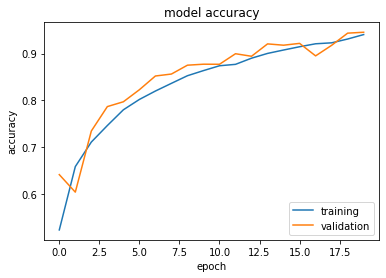

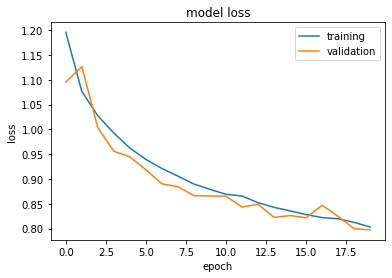

In [19]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot([a.cpu() for a in acc_hist[0]])
plt.plot([a.cpu() for a in acc_hist[1]])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# Store Infos

In [20]:
model_info = model.__str__()
datas = {
    'structure' : model_info,
    'acc' : acc_hist,
    'loss' : loss_hist,
}

import pickle
with open('/content/drive/MyDrive/BachelorResearch/src/train_my_model_stft_1d_features_3/datas/6.pickle', 'wb') as p:
    pickle.dump(datas, p)